# Comparing Mistral 7B and Mixtral 8x7B

In [1]:
import sys
sys.path.append('..')
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory

In [2]:
TOGETHER_API_KEY = "92a6ac4a8feb39c91b4a3f77219e9c452d927f5f4d543d5969cc11c210795719"
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")

In [6]:
prompt = "Are any medical symptoms mentioned in the transcript"
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)

binary task using: mistralai/Mistral-7B-Instruct-v0.1: 100%|██████████| 550/550 [00:07<00:00, 75.73it/s] 
binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1: 100%|██████████| 550/550 [00:57<00:00,  9.64it/s]


In [7]:
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b)
scorer_mistral7b.display_bootstrap_results(sample_size=len(data), output_type="text", n_samples=1000)

scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b)
scorer_mixtral8x7b.display_bootstrap_results(sample_size=len(data), output_type="text", n_samples=1000)

Bootstrapping: 100%|██████████| 1000/1000 [00:08<00:00, 112.27it/s]


accuracy: 0.6919 (0.6509-0.731 95% CI)
precision: 0.6919 (0.6509-0.731 95% CI)
recall: 1.0 (1.0-1.0 95% CI)
f1: 0.8178 (0.7885-0.8446 95% CI)


Bootstrapping: 100%|██████████| 1000/1000 [00:08<00:00, 111.27it/s]

accuracy: 0.8086 (0.7745-0.8382 95% CI)
precision: 0.8554 (0.8189-0.8898 95% CI)
recall: 0.8701 (0.8361-0.9021 95% CI)
f1: 0.8626 (0.8349-0.8867 95% CI)


make common plot

In [20]:
import matplotlib.pyplot as plt
import numpy as np
def compare_models_bootstrap(dict_scorers: dict, sample_size: int, n_samples = 1000):
    #TODO: compatible multitask?
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    metrics = ["accuracy", "precision", "recall", "f1"]
    bootstrap_results = {model: scorer.bootstrap(sample_size=sample_size, n_samples=n_samples) for model, scorer in dict_scorers.items()}
    for i, metric in enumerate(metrics):
        y = []
        y_lower = []
        y_upper = []
        for model in dict_scorers.keys():
            bootstrap_result = bootstrap_results[model] #NOT OK, DICT NOT ORDERED!
            y.append(np.mean(bootstrap_result[metric]))
            y_lower.append(bootstrap_result[metric].quantile(q=0.025))
            y_upper.append(bootstrap_result[metric].quantile(q=0.975))
        ax = axes[i // 2, i % 2]
        ax.bar([i+1 for i in range(len(dict_scorers))], y, yerr=[y_lower, y_upper], capsize=5, label=dict_scorers.keys())
        ax.set_title(metric.capitalize())
        ax.set_xlabel("Model")
        ax.set_ylabel("Value")
    fig.suptitle(f"Bootstrapped Comparison Results (nb samples={n_samples})")
    fig.legend()
    plt.tight_layout()
    plt.show()

Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapping:  34%|███▍      | 338/1000 [00:03<00:06, 105.19it/s]


KeyboardInterrupt: 

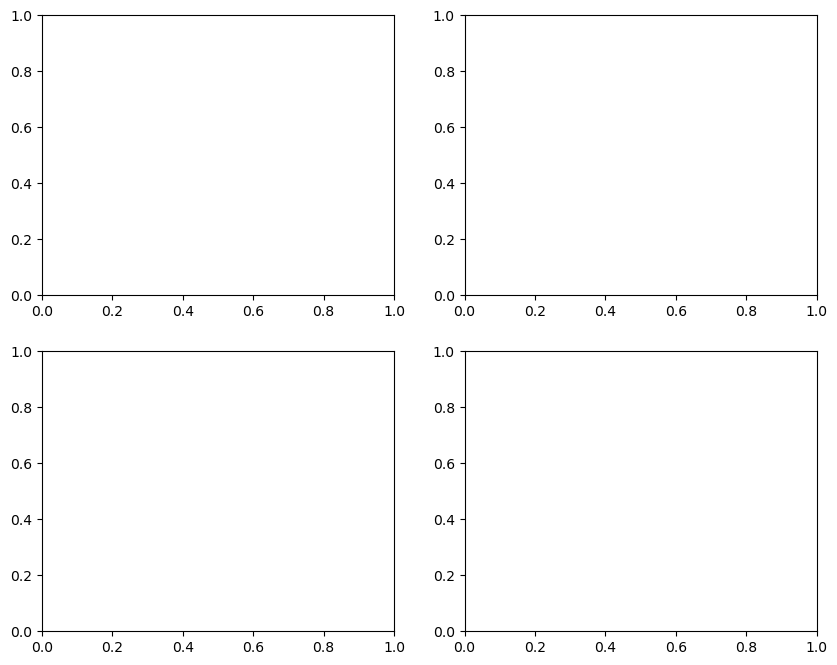

In [21]:
dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b}
compare_models_bootstrap(dict_scorers, sample_size=len(data), n_samples=1000)

error interrogation

In [15]:
import pandas as pd
df_mistral7b = pd.concat([data, results_mistral7b], axis=1)

In [16]:
df_mistral7b["Target_binary"] = df_mistral7b["Target_binary"].replace({"Positive": True, "Negative": False}).astype(bool)
df_mistral7b["Pred_status"] = df_mistral7b["Pred_status"].astype(bool)

In [17]:
df_different = df_mistral7b[df_mistral7b['Target_binary'] != df_mistral7b['Pred_status']]
df_different

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target_binary,Target_multilabel,Symptom Status_KS,Detailed Choices_KS,Pred_status
7,"P: Uhm, I know my grandfather had lung cancer,...",Negative,NaN,RES0181.txt,Negative,NaN,RES0181.txt,NaN,NaN,NaN,False,NaN,NaN,NaN,True
10,D: So just to make sure that we're being compr...,Negative,NaN,RES0181.txt,Negative,NaN,RES0181.txt,NaN,NaN,NaN,False,NaN,NaN,NaN,True
18,"P: Um nope. \n\nD: OK, any allergies? \n\nP: N...",Negative,NaN,RES0195.txt,Negative,NaN,RES0195.txt,NaN,NaN,NaN,False,NaN,NaN,NaN,True
19,D: OK. And currently right now do you work?\n\...,Negative,NaN,RES0195.txt,Negative,NaN,RES0195.txt,NaN,NaN,NaN,False,NaN,NaN,NaN,True
22,"P: No, that sounds great. Thank you so much.\n...",Negative,NaN,RES0195.txt,Negative,NaN,RES0195.txt,NaN,NaN,NaN,False,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,"P: It does, yeah, thank you.\n\nD: OK, yeah, n...",NaN,NaN,MSK0021.txt,Negative,NaN,MSK0021.txt,NaN,NaN,NaN,False,NaN,Negative,NaN,True
541,"P: Yeah, so cholesterol. I'm taking a like a C...",NaN,NaN,MSK0009.txt,Negative,NaN,MSK0009.txt,NaN,NaN,NaN,False,NaN,Negative,NaN,True
546,"P: No, I think that's all.",NaN,NaN,MSK0009.txt,Negative,NaN,MSK0009.txt,NaN,NaN,NaN,False,NaN,Negative,NaN,True
548,Ray of the right knee to to start OK.,NaN,NaN,MSK0009.txt,Negative,NaN,MSK0009.txt,NaN,NaN,NaN,False,NaN,Negative,NaN,True


In [18]:
count = len(df_different[(df_different['Target_binary'] == False) & (df_different['Pred_status'] == True)])
print(count)


170


In [20]:
df_mixtral8x7b = pd.concat([data, results_mixtral8x7b], axis=1)
df_mixtral8x7b["Target_binary"] = df_mixtral8x7b["Target_binary"].replace({"Positive": True, "Negative": False}).astype(bool)
df_mixtral8x7b["Pred_status"] = df_mixtral8x7b["Pred_status"].astype(bool)
df_different = df_mixtral8x7b[df_mixtral8x7b['Target_binary'] != df_mixtral8x7b['Pred_status']]
df_different

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target_binary,Target_multilabel,Symptom Status_KS,Detailed Choices_KS,Pred_status
3,D: Have you had any abdominal pain?\n\nP: No. ...,Positive,Constipation;Diarrhea;Fatigue;Pain;Rash;Other,RES0181.txt,Positive,Constipation;Diarrhea;Fatigue;Pain;Rash;Other,RES0181.txt,NaN,NaN,NaN,True,constipation;diarrhea;fatigue;other;pain;rash,NaN,NaN,False
4,"P: I use an insulin pump, yeah.\n\nD: OK, exce...",Positive,Anxiety;Other,RES0181.txt,Positive,Anxiety,RES0181.txt,Other,anxiety,NaN,True,anxiety,NaN,NaN,False
5,"D: OK. Uhm, and any hospitalizations or surger...",Positive,Cough;Other,RES0181.txt,Positive,Cough;Other,RES0181.txt,NaN,NaN,NaN,True,cough;other,NaN,NaN,False
6,"P: Uhm, so my younger sister had a sore throat...",Positive,Fever;Other,RES0181.txt,Positive,Fever;Other,RES0181.txt,NaN,NaN,NaN,True,fever;other,NaN,NaN,False
19,D: OK. And currently right now do you work?\n\...,Negative,NaN,RES0195.txt,Negative,NaN,RES0195.txt,NaN,NaN,NaN,False,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,"P: I do have, ah, asthma, so I I do take a, an...",NaN,NaN,MSK0021.txt,Negative,NaN,MSK0021.txt,NaN,NaN,NaN,False,NaN,Negative,NaN,True
527,"P: No, we've been at, been at home.\n\nD: OK. ...",NaN,NaN,MSK0021.txt,Positive,Other,MSK0021.txt,NaN,NaN,NaN,True,other,Positive,Other,False
540,"D: Alright, so have you had any recent weight ...",NaN,NaN,MSK0009.txt,Positive,Numbness and Tingling;Rash;Other,MSK0009.txt,NaN,NaN,NaN,True,numbness and tingling;other;rash,Positive,Numbness and Tingling;Rash;Other,False
543,"P: Yeah, I've been trying to just like stay re...",NaN,NaN,MSK0009.txt,Positive,Pain,MSK0009.txt,None;Pain,pain,Negative;Positive,True,pain,Negative,NaN,False


In [21]:
df_different.to_csv("test.csv", index=False)